In [2]:
import ast
import json
import math
from os import path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  
import seaborn as sns
import numpy as np
from Bio import SeqIO

# Figure 3: Rates of adaptation across the genomes of a diverse range of human pathogenic viruses

Plot the estimated rate of adaptation in all genes of the genome, for a handful of viruses, spanning different viral families, genome types and transmission modes

In [3]:
#calculated in Fig 2 notebook
threshold_antigenic_evo = {'bhatt': 0.96, 'kistler': 1.18}

In [4]:
#read in colors from the manuscript_colors config file
color_config_json = f'config/manuscript_colors.json'
with open(color_config_json) as json_handle:
    colors = json.load(json_handle)

In [5]:
def readin_virus_config(virus):
    config_json = f'config/adaptive_evo_config_{virus}.json'

    with open(config_json) as json_handle:
        configs = json.load(json_handle)
        
    return configs

In [6]:
def get_rates(virus_and_subtype, method, window, min_seqs):
    """
    Get rates of adaptation for each gene in the genome
    Return rates and 95CIs given in adaptive muts per codon per year x10-3
    """
    
    rates_by_gene = {}
    
    if 'dengue' in virus_and_subtype:
        virus = 'dengue'
        subtype = 'denv'+virus_and_subtype.split('dengue')[1]
        virus_and_subtype = 'dengue_'+subtype
    elif 'hepatitisA' in virus_and_subtype:
        virus = virus_and_subtype
        subtype=None
    else:
        if '_' in virus_and_subtype:
            virus = virus_and_subtype.split('_')[0]
            subtype = virus_and_subtype.split('_')[1]
        else:
            virus = virus_and_subtype
            subtype = None
    
    configs = readin_virus_config(virus)
    genes = configs['genes']
    
    #for viruses with under 12 years of analysis, use smaller windows
    #vic's pb2, pa and np only have 12 yrs
    if virus in ['h1n1pdm', 'vic', 'mumps']:
        if method=='kistler':
            window, min_seqs = 3, 3
        elif method=='bhatt':
            window, min_seqs = 3, 2
    
    for gene in genes:
        
        if method=='bhatt':
            json_name = f'bhatt_results/bhatt_results_nextstrain_{window}_{min_seqs}/{virus_and_subtype}_{gene}_bhatt_analysis_bootstrapped.json'
        elif method=='kistler':
            json_name = f'adaptation_results/results/{virus_and_subtype}_{gene}_{window}_{min_seqs}_adaptation_bootstrapped.json'

        if path.exists(json_name):
            with open(json_name) as json_handle:
                json_dict = json.load(json_handle)
                (window_midpoint, adaptive_substitutions, 
                 adaptive_substitutions_per_codon, 
                 rate_of_adaptation, bootstrap_adaptive_substitutions, 
                 bootstrap_adaptive_substitutions_per_codon, 
                 bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                                  json_dict['adaptive_substitutions'], 
                                                  json_dict['adaptive_substitutions_per_codon'], 
                                                  json_dict['rate_of_adaptation'], 
                                                  json_dict['bootstrap_adaptive_substitutions'], 
                                                  json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                                  json_dict['bootstrap_rate_of_adaptation'])
                
            bs_slope_sci = [x * (10**3) for x in bootstrap_rate_of_adaptation]
            lower_95ci = np.percentile(sorted(bs_slope_sci), 2.5)
            upper_95ci = np.percentile(sorted(bs_slope_sci), 97.5)
        if 'rotavirus' in virus_and_subtype:
            rota_segment_to_gene = {'A':'NSP1', 'C':'VP2', 'E':'NSP4', 'G':'VP7', 'I':'VP6', 
                            'M': 'VP3', 'N': 'NSP2', 'P':'VP4', 'R':'VP1', 'T':'NSP3'}
            rates_by_gene[rota_segment_to_gene[gene]] = {'rate':rate_of_adaptation* (10**3), 'upper_95ci':upper_95ci, 
                                   'lower_95ci':lower_95ci}

        else:
            rates_by_gene[gene.upper()] = {'rate':rate_of_adaptation* (10**3), 'upper_95ci':upper_95ci, 
                                   'lower_95ci':lower_95ci}


    
    return rates_by_gene

In [7]:
def x_coordinates(virus):
    """
    For all genes where rate of adaptation was calculated,
    Return the X position to plot the rate (so genes are shown in genome order). 
    Normalize all x-coordates to a total length of 8
    """
    
    configs = readin_virus_config(virus)
    genes = configs['genes']
    #order genes based on segment numbering
    if virus in ['h3n2', 'h1n1pdm', 'vic', 'yam']:
        genes = ['PB2', 'PB1', 'PA', 'ha1', 'ha2', 'NP', 'NA']
    if virus=='influenzaC':
        genes = ['PB2', 'PB1', 'P3','HEF1', 'HEF2', 'NP', 'M', 'NS']
    if 'rotavirus' in virus:
        rota_segment_to_gene = {'A':'NSP1', 'C':'VP2', 'E':'NSP4', 'G':'VP7', 'I':'VP6', 
                        'M': 'VP3', 'N': 'NSP2', 'P':'VP4', 'R':'VP1', 'T':'NSP3'}
        genes = [rota_segment_to_gene[g] for g in genes]
        
    space_between_genes = 8/(len(genes)-1)

    gene_x_positions = {}
    
    last_coord = 0
    for gene in genes:
        gene_x_positions[gene.upper()] = last_coord
        last_coord+=space_between_genes
    
    gene_labels = [g.upper() for g in genes]

    gene_labels = [legible_gene_titles[g] if g in legible_gene_titles.keys() else g for g in gene_labels]
    
    
    return gene_x_positions, gene_labels

In [8]:
#make gene names more legible
legible_gene_titles = {'PROTEIN4A': 'Protein 4A', 'PROTEIN4B': 'Protein 4B', 'PROTEIN3':'Protein 3', 'RDRP': 'RdRp', 
                       'POLYMERASE': 'Polymerase', 'LARGE':'Large', 'MIDDLE':'Middle', 
                       'SMALL':'Small', 'CORE':'Core', 'PROTEASE':'Protease', 
                       'PENTON':'Penton', 'HEXON':'Hexon', 'FIBER': 'Fiber', 'POL':'Pol', 'ORF1AB':'ORF1ab'}


In [9]:
#make the virus name more legible
legible_titles_viruses = {'rsv_A': 'RSV-A', 'rsv_B': 'RSV-B', 
                         '229e': 'Coronavirus 229E', 'oc43_A': 'Coronavirus OC43-A', 
                         'oc43_B': 'Coronavirus OC43-B', 'nl63': 'Coronavirus NL63', 
                          'measles': 'Measles', 'h3n2': 'Influenza A/H3N2', 
                          'vic': 'Influenza B/Vic', 'yam': 'Influenza B/Yam',
                          'influenzaC_Yamagata': 'Influenza C/Yamagata',
                          'enterovirusd68': 'Enterovirus D68', 'norovirus': 'Norovirus GII.4', 
                          'hepatitisB_A2':'HepatitisB-A2','dengue1_I': 'Dengue 1-I', 'dengue4_II': 'Dengue 4-II',
                          'hepatitisB_C':'hepatitisB-C','hepatitisB_D3':'HepatitisB-D3', 
                          'hepatitisA_IA': 'Hepatitis A-IA', 'hepatitisA_IB': 'Hepatitis A-IB', 
                          'rotavirusAg1p8': 'Rotavirus A/P[8]',
                          'adenovirusB7': 'Adenovirus B-7'}

In [10]:
#additional info for each virus
additional_info = {'h3n2': 'Orthomyxovirus \n- sense RNA, segmented \nEnveloped', 
                   'influenzaC': 'Orthomyxovirus \n- sense RNA, segmented \nEnveloped', 
                   'measles': 'Paramyxovirus \n- sense RNA \nEnveloped', 
                   'rsv': 'Paramyxovirus \n- sense RNA \nEnveloped', 
                   '229e': 'Coronavirus \n+ sense RNA \nEnveloped', 
                   'nl63': 'Coronavirus \n+ sense RNA \nEnveloped', 
                   'dengue': 'Flavivirus \n+ sense RNA \nEnveloped', 
                   'enterovirusd68': 'Picornavirus \n+ sense RNA \nNon-enveloped', 
                   'hepatitisA_IA': 'Picornavirus \n+ sense RNA \nNon-enveloped', 
                   'rotavirusAg1p8': 'Reovirus \ndsRNA, segmented \nNon-enveloped',
                   'hepatitisB': 'Hepadnavirus \nPartially dsDNA, circular \nEnveloped', 
                   'adenovirusB7': 'Adenovirus \ndsDNA \nNon-enveloped'}


In [11]:
#for each virus label which protein binds receptors
receptor_binder = {'h3n2': 'HA1', 'h1n1pdm': 'HA1', 'vic': 'HA1', 'yam': 'HA1','influenzaC_Yamagata':'HEF1', 
                   'measles': 'H', 'mumps':'HN', 'parainfluenza_1': 'HN', 'parainfluenza_3':'HN',
                   'oc43_A':'S1', '229e':'S1', 'nl63':'S1',
                   'dengue1_V':'E', 'dengue2_AA':'E', 'dengue3_III':'E', 'dengue4_II':'E', 
                   'rsv_A':'G', 'rsv_B':'G',
                   'enterovirusd68':'VP1', 'norovirus': 'VP1','hepatitisA_IA':'VP1', 
                   'rotavirusAg1p8': 'VP4', 'rotavirusAg1p4': 'VP4',
                   'hepatitisB_A2':'Large', 'hepatitisB_D3':'Large', 'parvovirusB19':'VP1',
                   'adenovirusB3':'Fiber', 'adenovirusB7':'Fiber'}


In [12]:
#for each virus label surface proteins that are not receptor-biding
other_surface = {'h3n2': ['HA2', 'NA'], 'h1n1pdm':['HA2', 'NA'], 'vic':['HA2', 'NA'], 'yam':['HA2', 'NA'], 'influenzaC_Yamagata': ['HEF2'], 
                 'measles': ['F'], 'mumps': ['F', 'SH'], 'parainfluenza_1': ['F'], 'parainfluenza_3': ['F'],
                 'oc43_A': ['S2', 'HE'], '229e':['S2'], 'nl63':['S2'],
                  'dengue1_V':[], 'dengue2_AA':[], 'dengue3_III':[], 'dengue4_II':[], 
                 'rsv_A': ['F', 'SH'], 'rsv_B': ['F', 'SH'],
                   'enterovirusd68':['VP2', 'VP3'], 'norovirus': [], 'hepatitisA_IA':['VP2', 'VP3'], 
                 'rotavirusAg1p8': ['VP7'], 'rotavirusAg1p4': ['VP7'],
                   'hepatitisB_A2':['Small', 'Middle'], 'hepatitisB_D3':['Small', 'Middle'], 'parvovirusB19': ['VP2'],
                 'adenovirusB3':['Penton','Hexon'], 'adenovirusB7':['Penton','Hexon']}


In [13]:
#map virus to viral family
virus_families = {'h3n2': 'Orthomyxovirus', 'h1n1pdm': 'Orthomyxovirus', 
                  'vic': 'Orthomyxovirus', 'yam': 'Orthomyxovirus', 
                  'influenzaC_Yamagata': 'Orthomyxovirus', 'measles': 'Paramyxovirus', 
                  'mumps': 'Paramyxovirus', 'parainfluenza_1': 'Paramyxovirus', 
                  'parainfluenza_3': 'Paramyxovirus', 'rsv_A': 'Paramyxovirus', 
                  'rsv_B': 'Paramyxovirus', 'oc43_A': 'Coronavirus', '229e': 'Coronavirus', 
                  'nl63': 'Coronavirus', 'dengue1_V': 'Flavivirus', 'dengue2_AA': 'Flavivirus', 
                  'dengue3_III': 'Flavivirus', 'dengue4_II': 'Flavivirus', 'rotavirusAg1p8': 'Reovirus', 
                  'rotavirusAg1p4': 'Reovirus', 'norovirus': 'Calicivirus', 'enterovirusd68': 'Picornavirus', 
                  'hepatitisA_IA': 'Picornavirus', 'hepatitisB_D3': 'Hepadnavirus', 
                  'hepatitisB_A2': 'Hepadnavirus', 'parvovirusB19': 'Parvovirus', 
                  'adenovirusB7': 'Adenovirus', 'adenovirusB3': 'Adenovirus'}

In [14]:
#all viruses
all_viruses = ['h3n2', 'h1n1pdm', 'vic', 'yam', 'influenzaC_Yamagata', 
               'measles', 'mumps', 'parainfluenza_1', 'parainfluenza_3', 'rsv_A', 'rsv_B',
               'oc43_A', '229e', 'nl63', 
               'dengue1_V', 'dengue2_AA', 'dengue3_III', 'dengue4_II', 
               'rotavirusAg1p8', 'rotavirusAg1p4', 'norovirus', 'enterovirusd68', 'hepatitisA_IA', 
               'hepatitisB_D3', 'hepatitisB_A2', 'parvovirusB19', 'adenovirusB7', 'adenovirusB3']

In [15]:
def summary_bar_charts(ax, to_plot, viruses, method, window, min_seqs):
    """
    Summary plot of which proteins (receptor-binding, surface, non-surface) 
    have rates of adaptation exceeding the threshold
    """
    #threshold of antigenic evo as calculated in Fig 2 notebook
    threshold = threshold_antigenic_evo[method]
    
    #count all the categories (types of protein, virus family),
    #displaying rates and those that are over or under the threshold
    under_over_threshold = []
    
    #viruses with at least one gene over threshold, viruses grouped by families
    families_adaptive_evo_count = {}
    
    #for each gene in each virus, find whether it is over or under threshold and aggregate data
    for virus in viruses:
        #get viral family
        family = virus_families[virus]
        virus_added_to_family_tally = False

        #count viruses per family
        if family not in families_adaptive_evo_count.keys():
            families_adaptive_evo_count[family] = {'total':1, 'over':0}
        else:
            families_adaptive_evo_count[family]['total']+=1
        
        #get rates of adaptation for each gene in this virus
        rates = get_rates(virus, method, window, min_seqs)
        #fix gene names
        rates_by_gene = {(legible_gene_titles[k] if k in legible_gene_titles.keys() else k.upper()):v for k,v in rates.items()}
        #list of all genes for this virus
        all_genes = list(rates_by_gene.keys())
        
        #get name of receptor-binding protein
        rb = receptor_binder[virus]
        
        #for viruses with at least one protein that exceeds threshold rate of adaptation, what is the fastest in the genome?
        fastest_rate_over_threshold = 0.0
        protein_w_fastest_rate = {}
        
    
        #remove rb gene from list, so that we'll be left with non-RB, non-surface genes
        all_genes.remove(rb)
        if rates_by_gene[rb]['rate'] > threshold:
            #increase count within family
            families_adaptive_evo_count[family]['over']+=1
            virus_added_to_family_tally = True
            
            fastest_rate_over_threshold  = rates_by_gene[rb]['rate']
            protein_w_fastest_rate = {'rate': rates_by_gene[rb]['rate'], 'protein': 'receptor-binding'}
            #add information about this virus/gene, if it is over the threshold
            under_over_threshold.append({'virus':virus, 'family':family, 'gene': rb, 'protein': 'RB', 
                                         'rate': rates_by_gene[rb]['rate'], 'threshold': 'over', 
                                         'threshold_hue': 'rb_over', 'dummy_x':'X'})
        else:
            #add information about this virus/gene, if it is under the threshold
            under_over_threshold.append({'virus':virus, 'family':family, 'gene': rb, 'protein': 'RB', 
                                         'rate': rates_by_gene[rb]['rate'], 'threshold': 'under', 
                                         'threshold_hue': 'rb_under', 'dummy_x':'X'})
            

        #get other surface proteins, and find whether they exceed threshold
        surface = other_surface[virus]
        for s in surface:
            all_genes.remove(s)
            if rates_by_gene[s]['rate'] > threshold:
                #if this virus hasn't already been tallied as one that has a gene over the threshold
                if virus_added_to_family_tally == False:
                    virus_added_to_family_tally = True
                    families_adaptive_evo_count[family]['over']+=1
                #add information about this virus/gene, if it is under the threshold
                under_over_threshold.append({'virus':virus, 'family':family, 'gene': s, 'protein': 'S', 
                                             'rate': rates_by_gene[s]['rate'], 'threshold': 'over', 
                                             'threshold_hue': 's_over', 'dummy_x':'X'})
                #check if rate is faster than the previously fastest-observed rate
                if rates_by_gene[s]['rate'] > fastest_rate_over_threshold:
                    fastest_rate_over_threshold  = rates_by_gene[s]['rate']
                    protein_w_fastest_rate = {'rate': rates_by_gene[s]['rate'], 'protein': 'surface'}
            else:
                #add information about this virus/gene, if it is under the threshold
                under_over_threshold.append({'virus':virus, 'family':family, 'gene': s, 'protein': 'S', 
                                             'rate': rates_by_gene[s]['rate'], 'threshold': 'under', 
                                             'threshold_hue': 's_under', 'dummy_x':'X'})
                
        #look at all other (nonsurface) genes
        for g in all_genes:
            if rates_by_gene[g]['rate'] > threshold:
                #if this virus hasn't already been tallied as one that has a gene over the threshold
                if virus_added_to_family_tally == False:
                    families_adaptive_evo_count[family]['over']+=1
                #add information about this virus/gene, if it is under the threshold
                under_over_threshold.append({'virus':virus, 'family':family, 'gene': g, 'protein': 'Non-S', 
                                             'rate': rates_by_gene[g]['rate'], 'threshold': 'over', 
                                            'threshold_hue': 'nons_over', 'dummy_x':'X'})
                #check if this gene's rate is fastest
                if rates_by_gene[g]['rate'] > fastest_rate_over_threshold:
                    fastest_rate_over_threshold  = rates_by_gene[g]['rate']
                    protein_w_fastest_rate = {'rate': rates_by_gene[g]['rate'], 'protein': 'non-surface'}
                
            else:
                #add information about this virus/gene, if it is under the threshold
                under_over_threshold.append({'virus':virus, 'family':family, 'gene': g, 'protein': 'Non-S', 
                                             'rate': rates_by_gene[g]['rate'], 'threshold': 'under', 
                                             'threshold_hue': 'nons_under', 'dummy_x':'X'})
                
    #make dataframe for all genes, viruses
    df = pd.DataFrame(under_over_threshold)


    if to_plot == 'total':
        cmap = {'over':'#8a00c2', 'under':'#bfbfbf'}
        strips = sns.stripplot(data=df, y='rate', x='dummy_x', size=3, hue='threshold', palette=cmap, 
                      alpha=0.6, jitter=0.3, ax=ax)
        ax.set_xlabel('All Proteins')
        ax.set_xticklabels([]) 
        ax.set_ylabel('Rate of\n adaptation', size=8)
        ax.legend_.remove()
        total_over = len(df[df['threshold']=='over'])
        ax.text(0.32, 1.08, f'{total_over}', color='#8a00c2',
                fontsize=10, horizontalalignment='center', transform=ax.transAxes)
        ax.text(0.58, 1.08, f'/{len(df)}', color='black',
                fontsize=10, horizontalalignment='center', transform=ax.transAxes)


    
    #summary figure to show which types of proteins have high rates of adaptation
    if to_plot == 'protein_type':
        
        cmap = {'rb_over':'#ff0800', 'rb_under': '#bfbfbf', 's_over':'#006ee6', 
                's_under': '#bfbfbf', 'nons_over':'#202020', 'nons_under': '#bfbfbf'}

#         sns.swarmplot(data = df, x='protein', y='rate', hue='threshold_hue', size=2.5, palette = cmap, ax=ax)
        sns.stripplot(data = df, x='protein', y='rate', hue='threshold_hue', size=2.5, jitter=0.3,
                      palette = cmap, ax=ax)
        
        #label number of genes over threshold for each category
        rb_over = len(df[(df['protein']=='RB')&(df['threshold']=='over')])
        rb_total = len(df[df['protein']=='RB'])
        ax.text(0.10, 1.08, f'{rb_over}', color=cmap['rb_over'],
                fontsize=10, horizontalalignment='center', transform=ax.transAxes)
        ax.text(0.18, 1.08, f'/{rb_total}', color='black',
                fontsize=10, horizontalalignment='center', transform=ax.transAxes)
        
        s_over = len(df[(df['protein']=='S')&(df['threshold']=='over')])
        s_total = len(df[df['protein']=='S'])
        ax.text(0.45, 1.08, f'{s_over}', color=cmap['s_over'],
                fontsize=10, horizontalalignment='center', transform=ax.transAxes)
        ax.text(0.52, 1.08, f'/{s_total}', color='black',
                fontsize=10, horizontalalignment='center', transform=ax.transAxes)
        
        nons_over = len(df[(df['protein']=='Non-S')&(df['threshold']=='over')])
        nons_total = len(df[df['protein']=='Non-S'])
        ax.text(0.76, 1.08, f'{nons_over}', color=cmap['nons_over'],
                fontsize=10, horizontalalignment='center', transform=ax.transAxes)
        ax.text(0.84, 1.08, f'/{nons_total}', color='black',
                fontsize=10, horizontalalignment='center', transform=ax.transAxes)
    
        ax.legend([], [], frameon=False)
        ax.set_xlabel('')
        ax.set_ylabel('Rate of\n adaptation', size=8)


    #summary figure to show 
    if to_plot == 'family':
        

        families = list(families_adaptive_evo_count.keys())
        family_labels = [x.split('virus')[0]+'-' for x in families]
        num_adaptive = [families_adaptive_evo_count[x]['over'] for x in families]
        num_non_adapt = [families_adaptive_evo_count[x]['total'] - families_adaptive_evo_count[x]['over'] for x in families]
        family_color_map = [colors['colors'][x] for x in families]
        color_gray = ['#bfbfbf' for x in families]
        
        width = 0.75
        
        bars_non = ax.bar(family_labels, num_non_adapt, width, color=color_gray, linewidth = 0)
        bars = ax.bar(family_labels, num_adaptive, width, bottom = num_non_adapt, 
                                color=family_color_map, linewidth = 0)
        for i in range(len(bars)):
            rect = bars[i]
            height = rect.get_height() + bars_non[i].get_height()
            ax.text(rect.get_x() + rect.get_width() / 2.0, height, f'{num_adaptive[i]}', 
                    ha='center', va='bottom', fontsize=8)
        
        plt.xticks(rotation=45, ha='right', fontsize=8)
        ax.set_yticks([0,3, 6])   
        ax.set_ylabel('Adaptively\nEvolving Viruses', linespacing=1.5, size=8)
        
        

    
    
                

In [74]:
def plot_rate_over_genome(viruses, method='kistler', window=5, min_seqs=3, filename=False):
    """
    For each virus, plot a cartoon of it's genome (or at least of the parts where rates were calculated)
    Above the cartoon, plot the rate of adaptation in this gene
    """
    
    num_rows_to_plot = int(round(len(viruses)/2))
    
    #plot styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['axes.labelweight'] = 'normal'
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['figure.dpi']= 300
    
    #initiate figure with "subfigures" for the summary plots and the genome-wide rates plot
    fig = plt.figure(layout='constrained',figsize=(8,2*(num_rows_to_plot)))
    subfigs = fig.subfigures(2, 1, hspace=0, height_ratios=[1,4.5])

    axsTop = subfigs[0].subplots(1, 3, sharey=False, sharex=False, gridspec_kw={'width_ratios': [1,2.5,3]})
    summary_fig_labels = ['A', 'B', 'C']
    label_offset = [-0.75, -0.25, -0.25]
    summary_to_plot = ['total', 'protein_type', 'family']
    for summary_index in range(len(axsTop)):
        a = axsTop[summary_index]
        a.text(label_offset[summary_index], 1.1, summary_fig_labels[summary_index], horizontalalignment='center', 
                       verticalalignment='center', weight='bold', fontsize=16, transform=a.transAxes)
        summary_bar_charts(a, summary_to_plot[summary_index], all_viruses, method, window, min_seqs)


    axs = subfigs[1].subplots(num_rows_to_plot, 2, gridspec_kw={'height_ratios': [2,1,1,1]})
    
    #figure panel labels
    fig_labels = ['D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
    
    
    #make a subplot for each virus
    for v in range(len(viruses)):
        virus_and_subtype = viruses[v]
        
        if 'dengue' in virus_and_subtype:
            virus = 'dengue'
            subtype = 'denv'+virus_and_subtype.split('dengue')[1]
        elif 'hepatitisA' in virus_and_subtype:
            virus = virus_and_subtype
            subtype=None
        else:
            if '_' in virus_and_subtype:
                virus = virus_and_subtype.split('_')[0]
                subtype = virus_and_subtype.split('_')[1]
            else:
                virus = virus_and_subtype
                subtype = None

        #get axis coordinates
        j=0
        if v%2!=0:
            j = 1
        i = math.floor(v/2)
        fig_index = 2*i+j
        
        #add figure panel labels
        #panel labels in the left column need to leave room for the y-ticks
        if j==0:
            axs[i, j].text(-0.15, 1.0, fig_labels[fig_index], horizontalalignment='center', 
                           verticalalignment='center', weight='bold', fontsize=16, transform=axs[i, j].transAxes)
        else:
            axs[i, j].text(-0.05, 1.0, fig_labels[fig_index], horizontalalignment='center', 
                           verticalalignment='center', weight='bold', fontsize=16, transform=axs[i, j].transAxes)
        
        #get rates of adaptation for each gene in this virus
        rates_by_gene = get_rates(virus_and_subtype, method, window, min_seqs)
        
        #get x-positions for genes
        gene_x_pos, gene_labels = x_coordinates(virus)

        
        x_ticks = []
        for gene, rates in rates_by_gene.items():
            rate = rates['rate']
            err_lower = rates['lower_95ci']
            err_upper = rates['upper_95ci']
            
            x_pos = gene_x_pos[gene]
            x_ticks.append(x_pos)
            
            #plot rate of adaptation and 95CI
            axs[i, j].vlines(x_pos, err_lower, err_upper, linewidth=1.5, color=colors['edge_colors'][virus_and_subtype])
            if rate >= threshold_antigenic_evo[method]:
                axs[i, j].plot(x_pos, rate, 'o', ms=12, color=colors['colors'][virus_and_subtype], 
                               markeredgewidth=2, markeredgecolor=colors['edge_colors'][virus_and_subtype])
            else:
                axs[i, j].plot(x_pos, rate, 'o', ms=12, color='white', 
                               markeredgewidth=2, markeredgecolor=colors['edge_colors'][virus_and_subtype])
        
        #truncate genome-wide plots for all rows except top
        if fig_index in [0,1]:
            axs[i, j].set_ylim(bottom=-0.5, top=7.5)
        else:
            axs[i, j].set_ylim(bottom=-0.5, top=3.5)

        #xticks with legible gene labels
        axs[i, j].set_xticks(sorted(x_ticks))
        axs[i, j].set_xticklabels(gene_labels, rotation=90) 
        
        #color the label for receptor binding protein, and other surface proteins
        label_colors = ['black' for x in range(len(gene_labels))]
        receptor_binding_protein = receptor_binder[virus_and_subtype]
        receptor_binding_protein_index = gene_labels.index(receptor_binding_protein)
        label_colors[receptor_binding_protein_index] = '#ff0800'
        #e50000
        other_surface_proteins = other_surface[virus_and_subtype]
        for sp in other_surface_proteins:
            other_surface_proteins_index = gene_labels.index(sp)
            label_colors[other_surface_proteins_index] = '#006ee6'
#             label_colors[other_surface_proteins_index] = '#ff9999'
        
        for xtick, label_color in zip(axs[i, j].get_xticklabels(), label_colors):
            xtick.set_color(label_color)


        #label the virus that is being plotted
        #and add info about the virus
        #have to adjust positioning depending on plot
        if fig_index in [0,1]:
            axs[i, j].text(0.02, 0.96, legible_titles_viruses[virus_and_subtype], fontsize=12, horizontalalignment='left', 
                       verticalalignment='center', transform=axs[i, j].transAxes)
            axs[i, j].text(0.02, 0.75, additional_info[virus], fontsize=8, horizontalalignment='left', 
                       verticalalignment='center', transform=axs[i, j].transAxes)
        else:
            axs[i, j].text(0.02, 1.0, legible_titles_viruses[virus_and_subtype], fontsize=12, horizontalalignment='left', 
                       verticalalignment='center', transform=axs[i, j].transAxes)
            axs[i, j].text(0.02, 0.64, additional_info[virus], fontsize=8, horizontalalignment='left', 
                       verticalalignment='center', transform=axs[i, j].transAxes)

        #label y-axis on first plot only
        if fig_index==0:
            axs[i, j].set_ylabel('Adaptive Muts per Codon \n per Year $(× 10^{-3})$')
            axs[i, j].yaxis.set_label_coords(-.13, .4)
            
        #put legend on top right
        if i==0 and j==1:
            handles = [Line2D([], [], color="white", marker='o', markerfacecolor="black", markersize=10, 
                              markeredgewidth=1.5, markeredgecolor="black"), 
                       Line2D([], [], color="white", marker='o', markerfacecolor="white", markersize=10, 
                              markeredgewidth=1.5, markeredgecolor="black")]
            leg = axs[i,j].legend(handles, [f'Rate >= threshold', f'Rate < threshold'],
                                  bbox_to_anchor=(1.0, 0.85), frameon=True, labelspacing = 1.25, borderpad=1)
            #add border    
            leg.get_frame().set_edgecolor('#808080')

                
    sns.despine()
    
#     plt.subplots_adjust(wspace=0.1, hspace=0.6)
#     fig.tight_layout(pad=0.7, h_pad=0.1)
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')
    


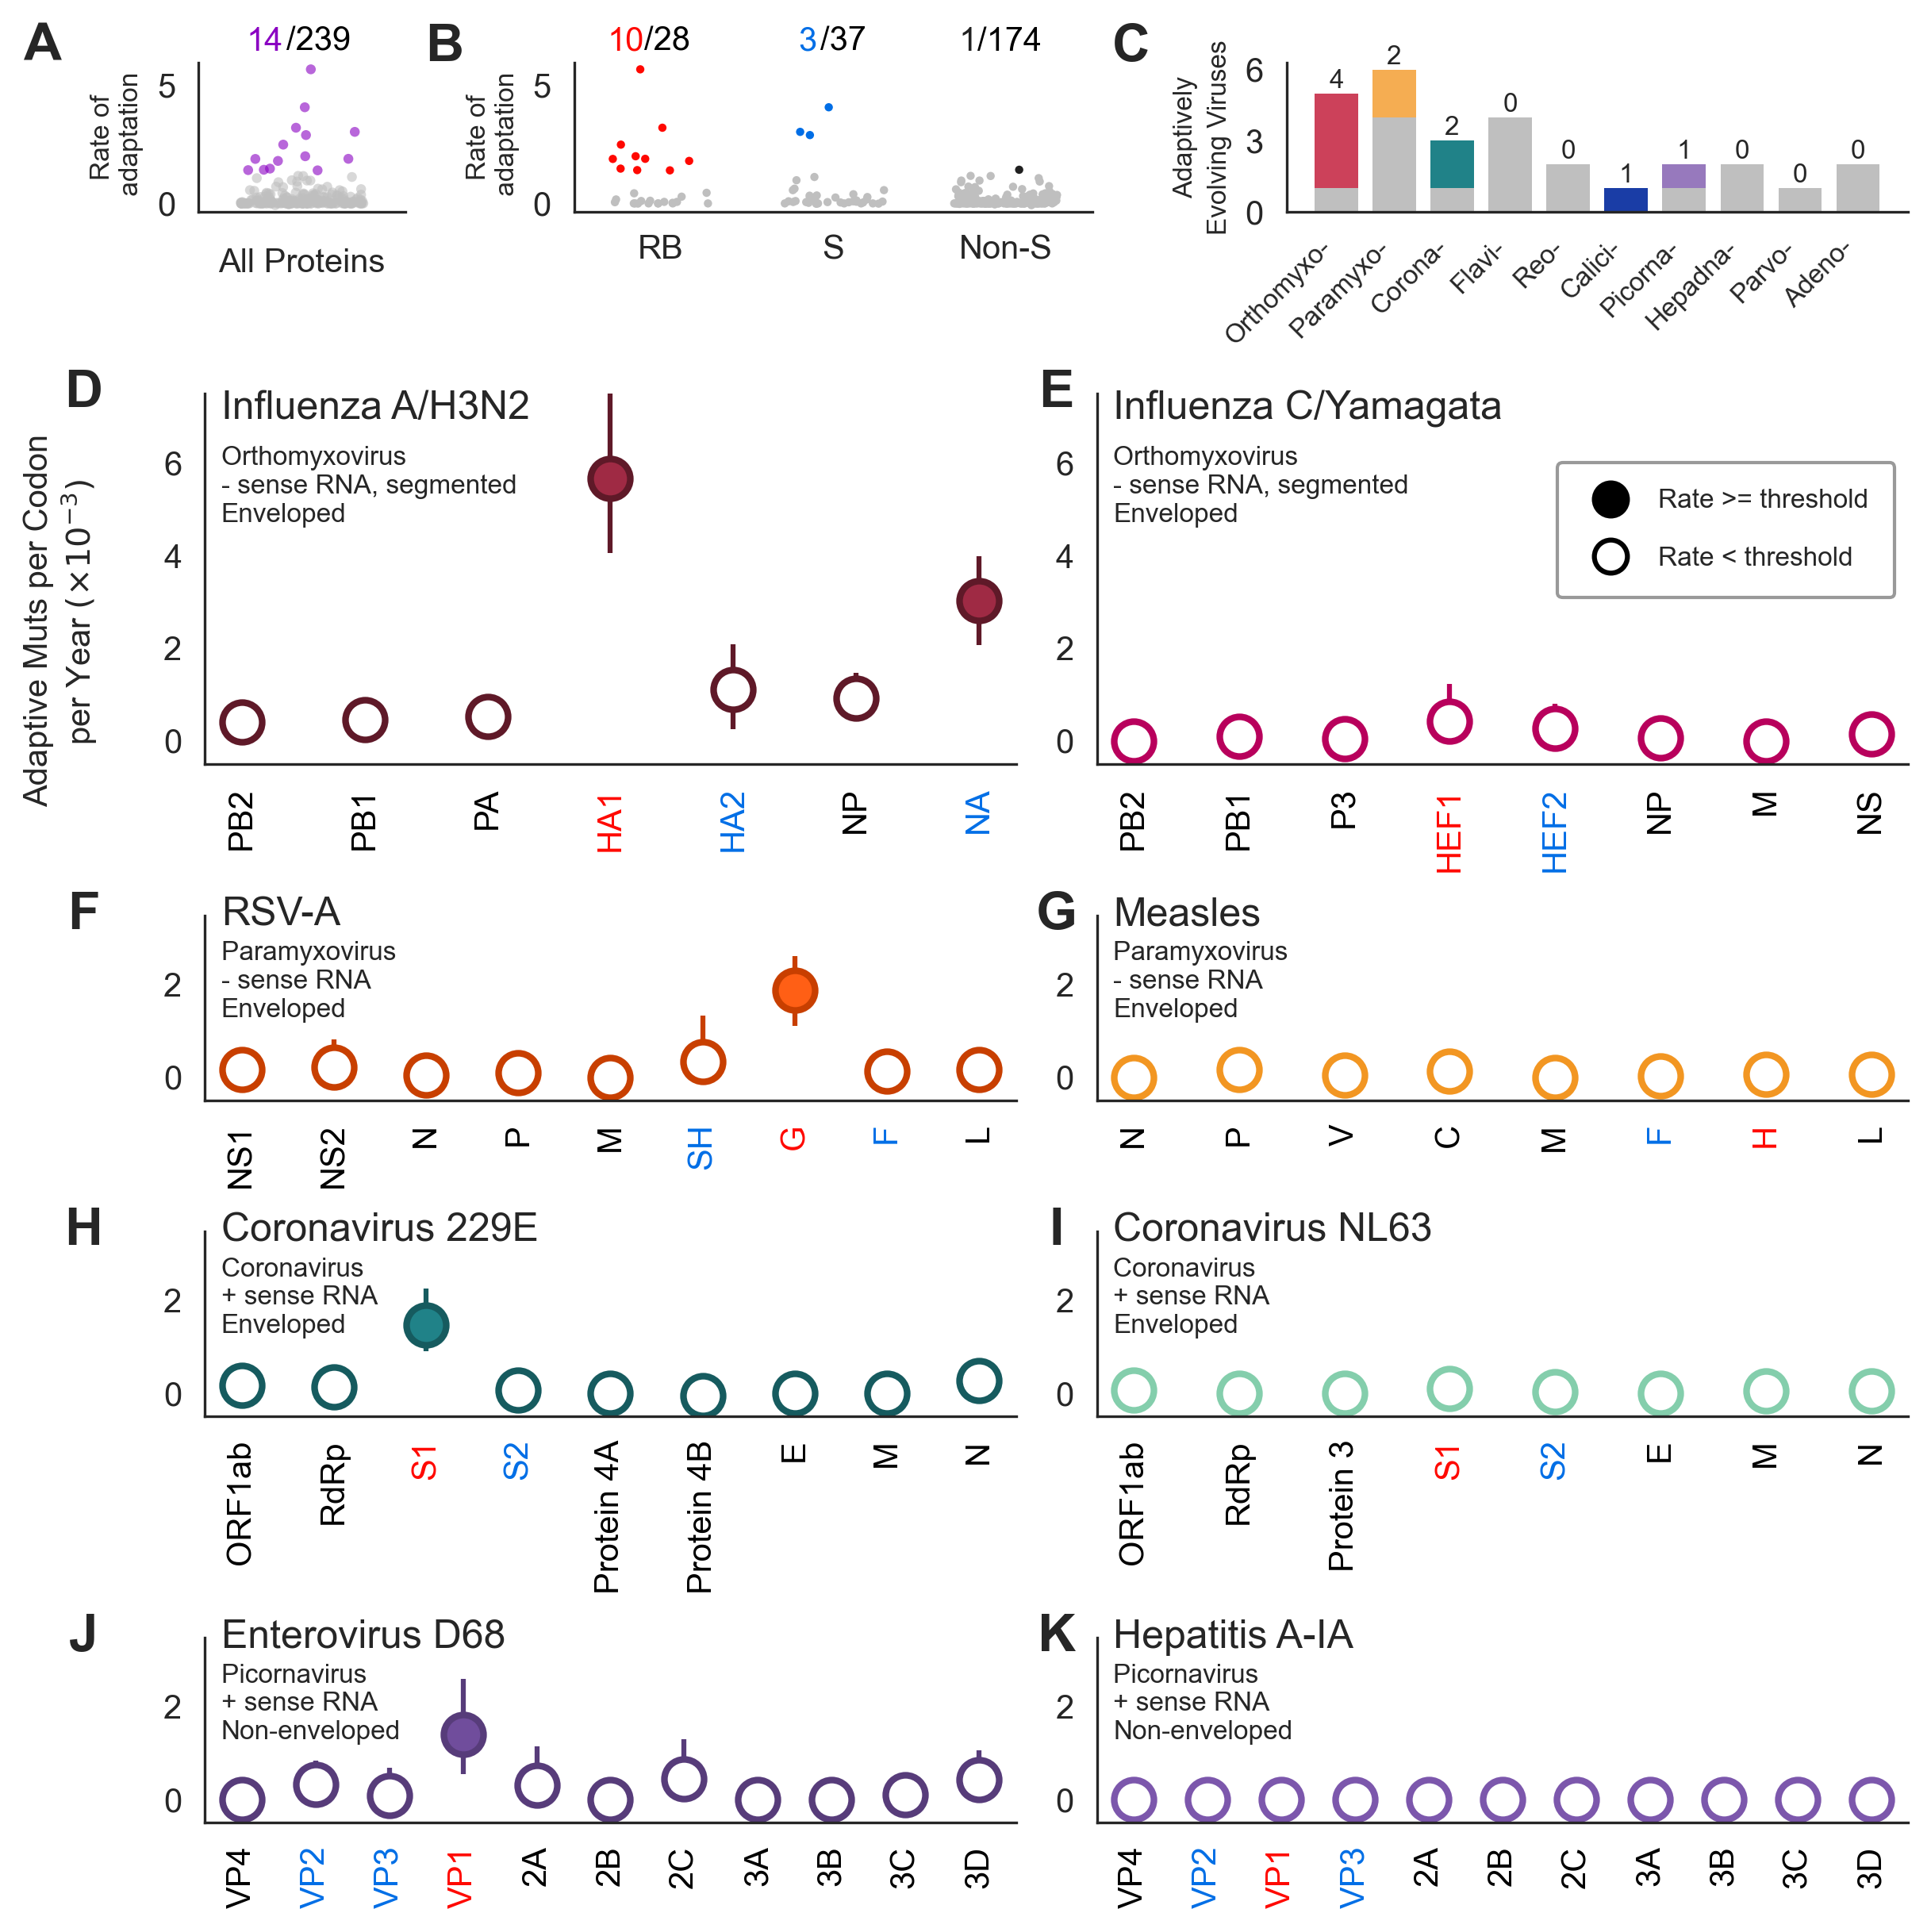

In [83]:
plot_rate_over_genome(['h3n2', 'influenzaC_Yamagata', 'rsv_A', 'measles', 
                       '229e', 'nl63', 'enterovirusd68', 'hepatitisA_IA'], 
                      filename = 'manuscript_figures/Figure3_Genomewide.png')